# Bonus Quiz 4A: Classification
## Predicting Injuries in Traffic Crashes
You will apply your Auto-ML to the [Chicago Traffic Crashes Dataset](https://data.cityofchicago.org/Transportation/Traffic-Crashes-People/u6pd-qa9d) to predict the extent of injury given the parameters of a vehicular crash.

<div class="alert alert-info">

**Instructions**
    
1. **Read the traffic crash data** from `traffic_crashes_people.csv`.
2. **Examine and clean the dataset** .
3. **Run your AutoML** on the preprocessed dataset.
4. **Discuss** the results and recommendations.

*Note: Attach any additional **module** or **package** that you will use alongside this exercise*
</div>

In [1]:
import time
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

warnings.filterwarnings("ignore")

from imblearn.over_sampling import SMOTE
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, OneHotEncoder
from sklearn.svm import LinearSVC

traffic_crashes_people_df = pd.read_csv("traffic_crashes_people.csv")

In [2]:
traffic_crashes_people_df.head()

,person_type,city,state,zipcode,sex,age,drivers_license_state,drivers_license_class,safety_equipment,driver_vision,physical_condition,airbag_deployed,ejection,injury_classification
0,DRIVER,HAZEL CREST,IL,60429,M,41.0,IL,NaN,USAGE UNKNOWN,NOT OBSCURED,NORMAL,DID NOT DEPLOY,NONE,NO INDICATION OF INJURY
1,DRIVER,NaN,NaN,NaN,X,NaN,NaN,NaN,USAGE UNKNOWN,UNKNOWN,UNKNOWN,DEPLOYMENT UNKNOWN,NONE,NO INDICATION OF INJURY
2,BICYCLE,CHICAGO,IL,60641,M,32.0,NaN,NaN,HELMET NOT USED,UNKNOWN,REMOVED BY EMS,NaN,TOTALLY EJECTED,INCAPACITATING INJURY
3,DRIVER,CHICAGO,IL,60639,M,NaN,IL,NaN,SAFETY BELT USED,UNKNOWN,NORMAL,DID NOT DEPLOY,NONE,NO INDICATION OF INJURY
4,PASSENGER,CHICAGO,IL,NaN,NaN,NaN,NaN,NaN,SAFETY BELT USED,NaN,NaN,NOT APPLICABLE,NONE,NO INDICATION OF INJURY


In [3]:
# Extract unique injury classifications
unique_injury_classifications = traffic_crashes_people_df[
    "injury_classification"
].unique()

# Print the list of unique injury classifications
for classification in unique_injury_classifications:
    print(classification)

NO INDICATION OF INJURY
INCAPACITATING INJURY
NONINCAPACITATING INJURY
REPORTED, NOT EVIDENT
FATAL
nan


In [4]:
# Remove unclassified injury
traffic_crashes_people_df.dropna(subset=["injury_classification"], inplace=True)

## Data Preprocessing [3 pts]

<div class="alert alert-info">
    
### Task 1 - Data Preprocessing [3 pts]
 1. Remove the three columns containing information obtained after the accident.
 2. One-hot encode all categorical columns.
 3. Check for other features that need cleaning in the dataset. Perform any filtering, dropping, transformation, imputation, etc. that you see fit. For example, you can bucket together all infrequent categorical levels into one using the `min_frequency` parameter of `sklearn.preprocessing.OneHotEncoder`.
</div>

In [5]:
data_cleaned = traffic_crashes_people_df.copy()

# Remove the three columns containing information obtained after the accident
data_cleaned.drop(
    columns=["airbag_deployed", "ejection", "injury_classification"], inplace=True
)

# Drop location, sex, age columns - seems insignificant in terms of accidents
# age - around 25% of the dataset is null
data_cleaned.drop(columns=["age", "zipcode", "city", "state"], inplace=True)

# One-hot encode all categorical columns
categorical_columns = [
    "person_type",
    "sex",
    "drivers_license_state",
    "drivers_license_class",
    "safety_equipment",
    "driver_vision",
    "physical_condition",
]

# Replace NaN values with 'UNKNOWN' for categorical columns
for column in categorical_columns:
    data_cleaned[column] = data_cleaned[column].fillna("UNKNOWN")

# One-hot encode categorical columns with handling of infrequent levels
encoder = OneHotEncoder(sparse=False, handle_unknown="ignore", min_frequency=0.05)
encoded_data = encoder.fit_transform(data_cleaned[categorical_columns])
encoded_columns = encoder.get_feature_names_out(categorical_columns)
encoded_data = pd.DataFrame(
    encoded_data, columns=encoded_columns, index=data_cleaned.index
)

# Combine the one-hot encoded data with the rest of the DataFrame
data_encoded = pd.concat(
    [data_cleaned.drop(columns=categorical_columns), encoded_data], axis=1
)

In [6]:
data_encoded.isnull().sum()

age                                         54399
person_type_DRIVER                              0
person_type_PASSENGER                           0
person_type_infrequent_sklearn                  0
sex_F                                           0
sex_M                                           0
sex_X                                           0
sex_infrequent_sklearn                          0
drivers_license_state_IL                        0
drivers_license_state_UNKNOWN                   0
drivers_license_state_infrequent_sklearn        0
drivers_license_class_D                         0
drivers_license_class_UNKNOWN                   0
drivers_license_class_infrequent_sklearn        0
safety_equipment_SAFETY BELT USED               0
safety_equipment_USAGE UNKNOWN                  0
safety_equipment_infrequent_sklearn             0
driver_vision_NOT OBSCURED                      0
driver_vision_UNKNOWN                           0
driver_vision_infrequent_sklearn                0


In [7]:
# age_summary_statistics = data_encoded['age'].describe()

# print("\nSummary Statistics for Age:\n", age_summary_statistics)


Summary Statistics for Age:
 count    147599.000000
mean         38.184669
std          17.100178
min         -49.000000
25%          26.000000
50%          36.000000
75%          50.000000
max         110.000000
Name: age, dtype: float64


In [8]:
# Check for other features that need cleaning and perform necessary operations
# data_encoded['age'].fillna(data_encoded['age'].median(), inplace=True)

In [9]:
data_encoded.isnull().sum()

age                                         0
person_type_DRIVER                          0
person_type_PASSENGER                       0
person_type_infrequent_sklearn              0
sex_F                                       0
sex_M                                       0
sex_X                                       0
sex_infrequent_sklearn                      0
drivers_license_state_IL                    0
drivers_license_state_UNKNOWN               0
drivers_license_state_infrequent_sklearn    0
drivers_license_class_D                     0
drivers_license_class_UNKNOWN               0
drivers_license_class_infrequent_sklearn    0
safety_equipment_SAFETY BELT USED           0
safety_equipment_USAGE UNKNOWN              0
safety_equipment_infrequent_sklearn         0
driver_vision_NOT OBSCURED                  0
driver_vision_UNKNOWN                       0
driver_vision_infrequent_sklearn            0
physical_condition_NORMAL                   0
physical_condition_UNKNOWN        

In [10]:
# # Initialize the MinMaxScaler
# scaler = MinMaxScaler()

# # Fit the scaler to the data and transform it
# data_normalized = scaler.fit_transform(data_encoded)

# # Convert the normalized array back to a DataFrame
# data_normalized_df = pd.DataFrame(data_normalized, columns=data_encoded.columns, index=data_encoded.index)

# data_normalized_df.head()

,age,person_type_DRIVER,person_type_PASSENGER,person_type_infrequent_sklearn,sex_F,sex_M,sex_X,sex_infrequent_sklearn,drivers_license_state_IL,drivers_license_state_UNKNOWN,...,drivers_license_class_infrequent_sklearn,safety_equipment_SAFETY BELT USED,safety_equipment_USAGE UNKNOWN,safety_equipment_infrequent_sklearn,driver_vision_NOT OBSCURED,driver_vision_UNKNOWN,driver_vision_infrequent_sklearn,physical_condition_NORMAL,physical_condition_UNKNOWN,physical_condition_infrequent_sklearn
0,0.566038,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,0.534591,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,0.509434,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
3,0.534591,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
4,0.534591,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [11]:
# Finalize X and y
X = data_encoded.copy()
y = traffic_crashes_people_df.loc[X.index, "injury_classification"]

In [12]:
# Encode for SMOTE
label_encoder = LabelEncoder()
y_encoded = pd.Series(label_encoder.fit_transform(y))

# Retrieve the mapping of encoded values to original labels
label_mapping = dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))
label_mapping

{'FATAL': 0,
 'INCAPACITATING INJURY': 1,
 'NO INDICATION OF INJURY': 2,
 'NONINCAPACITATING INJURY': 3,
 'REPORTED, NOT EVIDENT': 4}

In [13]:
smote = SMOTE(sampling_strategy="auto")
X_resampled_arr, y_resampled_arr = smote.fit_resample(X, y_encoded)

X_resampled = pd.DataFrame(X_resampled_arr, columns=X.columns)
y_resampled = pd.DataFrame(y_resampled_arr, columns=["injury_classification"])

In [14]:
X_resampled.columns

Index(['age', 'person_type_DRIVER', 'person_type_PASSENGER',
       'person_type_infrequent_sklearn', 'sex_F', 'sex_M', 'sex_X',
       'sex_infrequent_sklearn', 'drivers_license_state_IL',
       'drivers_license_state_UNKNOWN',
       'drivers_license_state_infrequent_sklearn', 'drivers_license_class_D',
       'drivers_license_class_UNKNOWN',
       'drivers_license_class_infrequent_sklearn',
       'safety_equipment_SAFETY BELT USED', 'safety_equipment_USAGE UNKNOWN',
       'safety_equipment_infrequent_sklearn', 'driver_vision_NOT OBSCURED',
       'driver_vision_UNKNOWN', 'driver_vision_infrequent_sklearn',
       'physical_condition_NORMAL', 'physical_condition_UNKNOWN',
       'physical_condition_infrequent_sklearn'],
      dtype='object')

## Data Segregation [1 pt]

<div class="alert alert-info">

### Task 2 - Data Segregation [1 pt]
 1. Use the last 1000 rows as the final test dataset; the remaining as train/validation dataset.
 2. Use a smaller sample **(of at least 8k rows)** as the train/val set in the interest of time.
 3. Set `random_state=1337` to make your sampling procedure reproducible.
</div>

In [15]:
# Merge X and y temporarily to simplify sampling
data_resampled = pd.concat([X_resampled, y_resampled], axis=1)

# Sample indices
sample_indices = data_resampled.sample(n=8000, random_state=1337).index

# Separate X and y samples
X_sample = X_resampled.loc[sample_indices]
y_sample = y_resampled.loc[sample_indices]

# Check the shapes to ensure they match
print("X Sample Shape:", X_sample.shape)
print("y Sample Shape:", y_sample.shape)

X Sample Shape: (8000, 23)
y Sample Shape: (8000, 1)


In [16]:
X_sample.head()

,age,person_type_DRIVER,person_type_PASSENGER,person_type_infrequent_sklearn,sex_F,sex_M,sex_X,sex_infrequent_sklearn,drivers_license_state_IL,drivers_license_state_UNKNOWN,...,drivers_license_class_infrequent_sklearn,safety_equipment_SAFETY BELT USED,safety_equipment_USAGE UNKNOWN,safety_equipment_infrequent_sklearn,driver_vision_NOT OBSCURED,driver_vision_UNKNOWN,driver_vision_infrequent_sklearn,physical_condition_NORMAL,physical_condition_UNKNOWN,physical_condition_infrequent_sklearn
800922,0.503145,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
595875,0.700120,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
912305,0.452830,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
125256,0.534591,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
83059,0.635220,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [17]:
y_sample.head()

,injury_classification
800922,4
595875,3
912305,4
125256,2
83059,2


## Model Experimentation [4 pts]

<div class="alert alert-info">

### Task 3 - Model Experimentation [4 pts]
 1. Use at least two (2) tree-based models and one (1) non-tree based model.
 2. Use `3` trials for monte-carlo CV or `k >= 3` for k-fold CV.
 3. Set a validation size of `20%`.
 4. Grid search over the following hyperparameters:
        - max depth of `2` to `5`
        - number of estimators of at least `50`
        - C or alpha [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4]
</div>

In [18]:
no_of_trials = 3
test_size = 0.2
param_grid = {
    "max_depth": [2, 3, 4, 5],
    "n_estimators": [50, 100, 200, 300],
}


def train_svm(X, y, reg):
    C = [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4]
    score_train = []
    score_test = []
    weighted_coefs = []

    for seed in range(no_of_trials):
        training_accuracy = []
        test_accuracy = []
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.25, random_state=seed
        )
        for alpha_run in C:
            if reg == "l1":
                svc = LinearSVC(
                    C=alpha_run, penalty=reg, loss="squared_hinge", dual=False
                ).fit(X_train, y_train)
            if reg == "l2":
                svc = LinearSVC(C=alpha_run, penalty=reg).fit(X_train, y_train)
            training_accuracy.append(svc.score(X_train, y_train))
            test_accuracy.append(svc.score(X_test, y_test))
            coefs = svc.coef_
            weighted_coefs.append(coefs)

        score_train.append(training_accuracy)
        score_test.append(test_accuracy)

    mean_coefs = np.mean(weighted_coefs, axis=0)
    score = np.mean(score_test, axis=0)

    top_predictor = X.columns[np.argmax(np.abs(mean_coefs))]
    abs_mean_coefs = np.abs(mean_coefs[0, :])
    coefs_count = len(abs_mean_coefs)
    fig, ax = plt.subplots(figsize=(3, 20))
    ax.barh(np.arange(coefs_count), sorted(abs_mean_coefs))

    ax.set_yticks(np.arange(coefs_count))
    ax.set_yticklabels(X.columns[np.argsort(abs_mean_coefs)])

    run_time = time.time() - start_time
    return [
        "Linear SVM ({0})".format(reg),
        np.amax(score),
        "C = {0}".format(C[np.argmax(score)]),
        top_predictor,
        run_time,
    ]


def train_gradientboost(X, y):
    start_time = time.time()
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=1337
    )
    gb_classifier = GradientBoostingClassifier(random_state=1337)
    gb_grid_search = GridSearchCV(gb_classifier, param_grid, cv=no_of_trials)
    gb_grid_search.fit(X_train, y_train)
    score = gb_grid_search.best_estimator_.score(X_test, y_test)

    run_time = time.time() - start_time
    return [
        "Gradient Boosting",
        score,
        gb_grid_search.best_params_,
        np.argmax(gb_grid_search.best_estimator_.feature_importances_),
        run_time,
    ]


def train_randomforest(X, y):
    start_time = time.time()
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=1337
    )
    rf_classifier = RandomForestClassifier(random_state=1337)
    rf_grid_search = GridSearchCV(rf_classifier, param_grid, cv=no_of_trials)
    rf_grid_search.fit(X_train, y_train)
    score = rf_grid_search.best_estimator_.score(X_test, y_test)

    run_time = time.time() - start_time
    return [
        "Random Forest",
        score,
        rf_grid_search.best_params_,
        np.argmax(rf_grid_search.best_estimator_.feature_importances_),
        run_time,
    ]

['Gradient Boosting', 0.538125, {'max_depth': 5, 'n_estimators': 300}, 0, 329.35014367103577]
329.35014367103577 seconds
['Random Forest', 0.451875, {'max_depth': 5, 'n_estimators': 200}, 14, 25.49681830406189]
25.49681830406189 seconds
['Linear SVM (l2)', 0.393, 'C = 0.01', 'sex_X', 24.629005908966064]
24.629005908966064 seconds


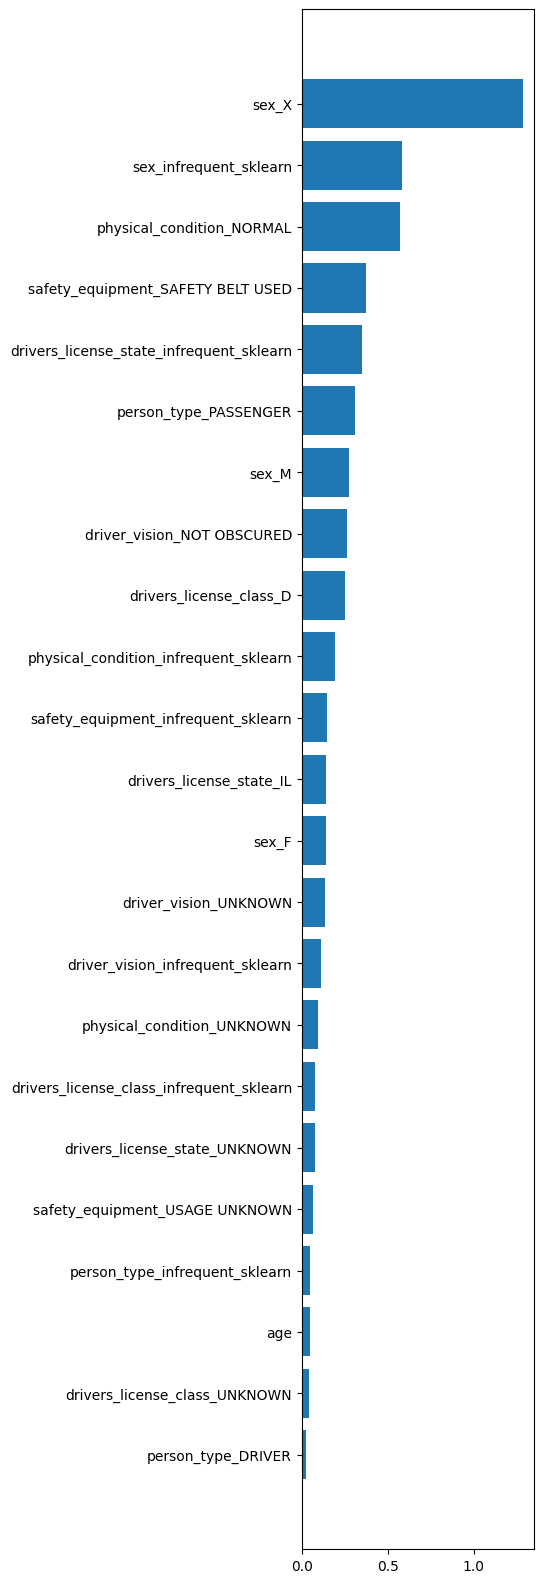

In [19]:
start_time = time.time()
a = train_gradientboost(X_sample, y_sample)
print(a)
print("%s seconds" % a[4])

start_time = time.time()
b = train_randomforest(X_sample, y_sample)
print(b)
print("%s seconds" % b[4])

start_time = time.time()
c = train_svm(X_sample, y_sample, reg="l2")
print(c)
print("%s seconds" % c[4])

## Model Results and Discussion [4 pts]

<div class="alert alert-info">
    
### Task 4 - Model Results and Discussion [4 pts]
 1. Display a summary table with the following information: train accuracy, val/test accuracy, best parameter, train time, and top predictor.
 2. Justify what model you will use? At what hyperparameter? Why?
 3. Generate the feature importance plot of your chosen best model.
 4. Give insights on the features deemed important by the best model.    
</div>

In [20]:
cols = [
    "Machine Learning Method",
    "Test Accuracy",
    "Best Parameter",
    "Top Predictor Variable",
    "Run Time",
]
df2 = pd.DataFrame(columns=cols)

df2.loc[0] = a
df2.loc[1] = b
df2.loc[2] = c

df2

,Machine Learning Method,Test Accuracy,Best Parameter,Top Predictor Variable,Run Time
0,Gradient Boosting,0.538125,"{'max_depth': 5, 'n_estimators': 300}",0,329.350144
1,Random Forest,0.451875,"{'max_depth': 5, 'n_estimators': 200}",14,25.496818
2,Linear SVM (l2),0.393000,C = 0.01,sex_X,24.629006


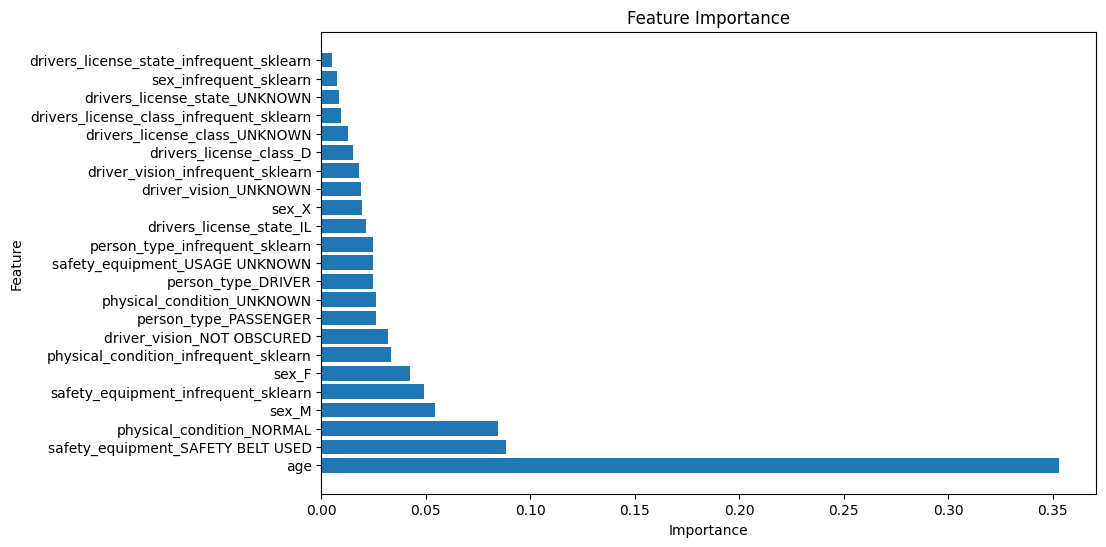

In [21]:
best_model = GradientBoostingClassifier(
    random_state=1337, max_depth=5, n_estimators=300
)

# Train your best model on the entire dataset
best_model.fit(
    X_sample, y_sample
)  # Replace X_train and y_train with your training data

# Retrieve feature importances
feature_importances = best_model.feature_importances_

# Create a DataFrame to store feature importances with corresponding feature names
importance_df = pd.DataFrame({"Feature": X.columns, "Importance": feature_importances})

# Sort the DataFrame by importance values
importance_df = importance_df.sort_values(by="Importance", ascending=False)

# Plot the feature importances
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(importance_df["Feature"], importance_df["Importance"])
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importance")
plt.show()

## Business Value Articulation

<div class="alert alert-block alert-info">
    
### Task 5 - Business Value Articulation [3 pts]

Understanding the analysis results using any of the machine learning models you have implemented above, write guidelines, criteria, or recommendations for triage to be used by emergency personnel for these types of accidents (2-4 sentences or bullet points). [3 pts]
</div>

Your answer here

## Bonus [1 pt]

</div><div class="alert alert-info">

### Task 6 - Bonus [1 pt]
 1. Predict on the final test set (last 1000 rows of original data) using your best-performing model.
 2. Show and comment on the resulting confusion matrix.
    
</div>

In [22]:
data = pd.concat([X, y_encoded], axis=1)

# Get last 1000 rows of original data
last_1000_indices = data.tail(1000).index
X_test_final = X.loc[last_1000_indices]
y_test_final = y_encoded.loc[last_1000_indices]

y_pred_final = best_model.predict(X_test_final)

# Get the unique class labels from y_test_final and sort them alphabetically
class_labels = sorted(y_test_final.unique())

# Append labels indicating whether the labels represent predicted or actual values
index_labels = [f"Actual: {label}" for label in class_labels]
column_labels = [f"Predicted: {label}" for label in class_labels]

# Compute and analyze the confusion matrix
conf_matrix = confusion_matrix(y_test_final, y_pred_final)

# Create a DataFrame for the confusion matrix with labeled rows and columns
conf_matrix_df = pd.DataFrame(conf_matrix, index=index_labels, columns=column_labels)

conf_matrix_df

KeyError: '[3582, 4473, 10174, 24561, 30348, 48274, 51156, 55976, 56122, 56704, 61671, 62268, 66119, 66378, 71415, 71664, 72608, 78386, 80768, 81126, 83085, 83353, 85049, 90064, 93913, 96824, 98234, 103345, 104921, 105227, 105644, 106842, 107366, 109091, 111332, 115171, 115448, 119951, 121072, 121534, 125025, 125026, 129793, 130817, 132771, 136581, 145943, 146261, 146263, 146598, 146760, 149314, 151430, 151507, 151900, 154576, 154985, 159625, 160563, 160941, 163035, 165073, 166131, 166132, 170813, 171367, 181688, 184720, 184813, 188591, 189559, 189560, 192475, 193956, 198423, 199888, 200194, 200754] not in index'

In [ ]:
from sklearn.metrics import precision_score, recall_score

# Calculate precision
precision = precision_score(y_test_final, y_pred_final, average=None)

# Calculate recall
recall = recall_score(y_test_final, y_pred_final, average=None)

print("Precision:", precision)
print("Recall:", recall)